<a href="https://colab.research.google.com/github/CLAIR-LAB-TECHNION/ICAPS-24/blob/main/notebooks/ICAPS_SummerSchool_Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

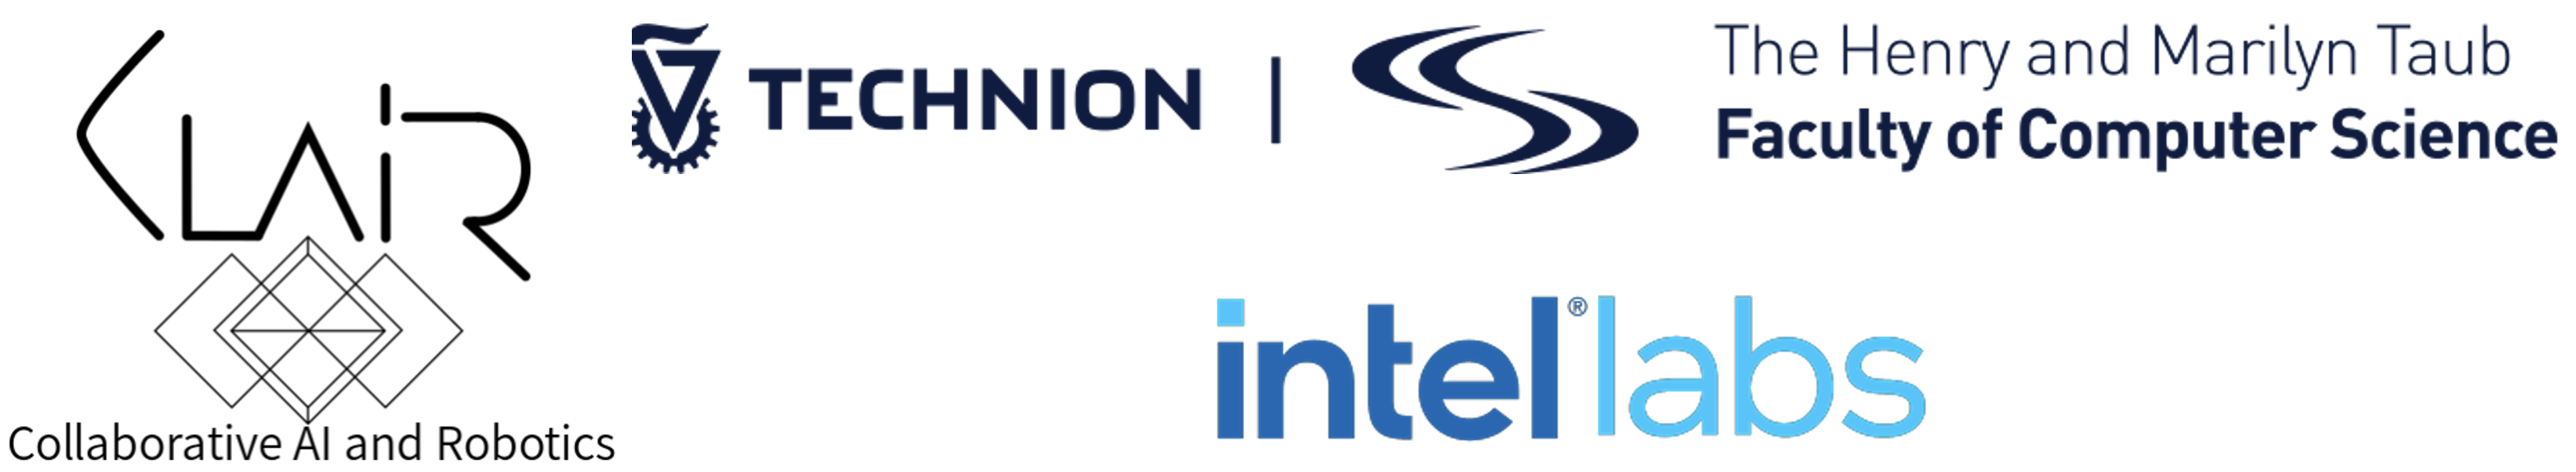

#### Yuval Goshen, Guy Azran, Sarah Keren

# Integrated Task and Motion Planning (TAMP)

Our focus is on exploring settings in which robotic agents need to perform complex tasks that require high-level reasoning and planning, on one hand,
and an understanding of how to move and operate in the physical environment, on the other hand.
Since we are interested in complex tasks, simply learning an optimal policy from previously performed trajectories is insufficient.

In our settings of interest, we require both the ability to perform **task planning**, which focuses on high-level decision-making and on choosing a sequence of actions that should be executed to achieve a goal, and **motion planning**, which deals with the low-level details of generating feasible motions to execute those tasks safely and efficiently.

# Running example:  N-table Blocks World

You are probably familer with the blocks world (BW) domain, a classic problem domain used for testing automated planning methods and systems. A problem instance (see example below) typically involves a set of blocks of different shapes and sizes that can be stacked on top of each other. The goal is to move blocks from an initial configuration to a desired final configuration, using a set of actions.


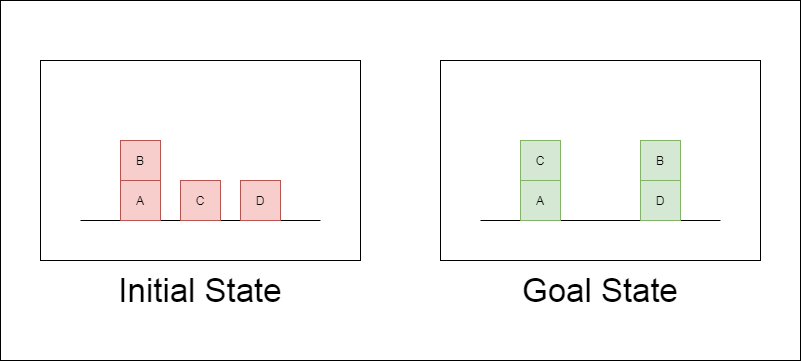


Image from:
ttps://apoorvdixit619.medium.com/goal-stack-planning-for-blocks-world-problem-41779d090f29

In its basic form, BW comprises the following elements:

**Blocks**: there are several blocks, each with a unique identifier. Here, blocks are represented by letters (A, B, C, D).

**Initial State:** the initial configuration of the blocks, including the positions of each block.

**Goal State:** The desired final configuration of the blocks.

**Actions:** A set of actions that can be performed to manipulate the blocks. Common actions include picking up a block, putting down a block, and stacking one block on top of another. Each action has preconditions (conditions that must be true for the action to be applicable) and effects (changes that occur when the action is executed).



BW is often used as an introductory example of automated planning because it's simplified form is simple to understand yet complex enough to demonstrate important planning concepts and challenges.
To solve a BW planning problem, a state space search is typically performed to find a sequence of actions that transforms the initial state into the goal state.

## N-Table Blocks World

There are many ways to extend the basic setting which introduces various forms of complexity. With our wish to focus on challenges for robotic agents, we present an extension of BW to multi-table settings, in which blocks are distributed between n surfaces (i.e., tables). The goal specification considers a configuration of blocks for a subset of tables.


![duck.png](https://raw.githubusercontent.com/CLAIR-LAB-TECHNION/ICAPS-24/main/assets/figures/n_table_genAI.png)



❓**What are the key changes from the basic setting that need to be considered here?**

# Modeling NTBW with PDDL

There are many ways to model this setting with PDDL. One option is given below, where we add the table as a parameter to the relevant predicates and action descriptions.

In [ ]:
DOMAIN = """
(define (domain n-table-blocks-world)
  (:requirements :strips :typing :equality)
  (:types block color table)
  (:predicates (on ?b1 ?b2 - block)
	           (ontable ?b - block ?t -table)
	           (clear ?b - block)
	           (handempty)
	           (holding ?b - block)
	           (bcolor ?b - block ?c -color)
 )

  (:action pick-up
	     :parameters (?b - block ?t - table)
	     :precondition (and (clear ?b)(ontable ?b ?t)(handempty))
	     :effect
	     (and (not (ontable ?b ?t))
		   (not (clear ?b))
		   (not (handempty))
		   (holding ?b)))

  (:action put-down
	     :parameters (?b - block ?t - table)
	     :precondition (holding ?b)
	     :effect
	     (and (not (holding ?b))
		   (clear ?b)
		   (handempty)
		   (ontable ?b ?t)))

  (:action stack
	     :parameters (?b1 ?b2 - block)
	     :precondition (and (holding ?b1) (clear ?b2))
	     :effect
	     (and (not (holding ?b1))
		   (not (clear ?b2))
		   (clear ?b1)
		   (handempty)
		   (on ?b1 ?b2)))

  (:action unstack
	     :parameters (?b1 ?b2 - block)
	     :precondition (and (on ?b1 ?b2) (clear ?b1)(handempty))
	     :effect
	     (and (holding ?b1)
		   (clear ?b2)
		   (not (clear ?b1))
		   (not (handempty))
		   (not (on ?b1 ?b2)))))

"""

In [ ]:
PROBLEM = """
(define (problem 3t5b)
(:domain n-table-blocks-world)
(:objects
B1 B2 B3 B4 B5 - block
Y B G R P - color
T1 T2 T3  - table
)
(:init
(handempty)

(ontable B1 T1)
(bcolor B1 Y)

(on B2 B1)
(clear B2)
(bcolor B2 B)

(ontable B3 T2)
(clear B3)
(bcolor B3 Y)

(ontable B4 T3)
(clear B4)
(bcolor B4 G)

(ontable B5 T3)
(clear B5)
(bcolor B5 R)

)
(:goal (and
(on B3 B1)
))
)
"""

❓ **Is this a good enough representation? Otherwise, what's missing here to capture some of the complexities of the real-world setting?**

We will dive into this question later on. Let's first examine how we can solve it using state-space search.

# Task Planning with AIDM

With our PDDL representation of the NTBW setting, we want to solve it. For this, we will use the search methods that we have implemented at the CLAIR lab at the Technion. The [**aidm**](https://github.com/CLAIR-LAB-TECHNION/aidm) library contains different approaches to AI decision-making, but for now, we will focus on the state space search methods.

**Important note !** Using aidm is just our choice because it's the library we are developing and working with. If you prefer, you can use any available planner or solver, such as the unified-planning library https://github.com/aiplan4eu/unified-planning.


Let's install the library from github

In [ ]:
!pip install "aidm[pddl] @ git+https://github.com/CLAIR-LAB-TECHNION/aidm"

Now, let's import the class that accepts a PDDL representation of a problem (based on code by https://github.com/tomsilver/pddlgym).


In [ ]:
from aidm.environments.pddl.pddl_problem import PDDLProblem


We initialize the PDDL problem with the descriptions (you can change DOMAIN and PROBLEM to any definitions you choose)

In [ ]:
problem = PDDLProblem(domain=DOMAIN, problem=PROBLEM)

We import the search algorithms we want to run, which are all special cases of Best First Search and can therefore be found in our best_first_search module

We start by running blind (or uninformed) search methods that do not maintain information about the problem other than how to traverse the state space. We will use them to search for a path from an initial state to a **goal state**, i.e., a state that satisfies a specified goal condition.

In [ ]:
from aidm.search.best_first_search import breadth_first_search

Run Breadth First Search

In [ ]:
[best_node, best_plan, resources] = breadth_first_search(problem=problem,
                                                          iter_limit=1000,
                                                          logging=False)


You can use our print_results method to see the results and the resources used for the search

In [ ]:
from aidm.core.utils import print_results

In [ ]:
print_results(info='breadth_first_search', node=best_node, plan=best_plan, resources=resources)


Run Depth-First Search (DFS). You can set a bound on the number of explored nodes by adding the iter_limit argument, e.g., iter_limit=100

In [ ]:
from aidm.search.best_first_search import depth_first_search

In [ ]:
[best_node, best_plan, resources] = depth_first_search(problem=problem,use_closed_list=True, logging=False)


In [ ]:
print_results(info='depth_first_search', node=best_node, plan=best_plan, resources=resources)


All these methods are special cases of Best First Search, which accepts as input:

1. a frontier, which defines the order by which nodes are explored
2. a termination criteria, defining at which point the search should stop (i.e., what we are looking for)
3. a pruning function, that is used to reduce the search space
4. a flag defining whether a closed list is used to avoid re-exploring nodes

There are additional parameters that can be defined, but these are the important ones. You are welcome to explore the other options [here](https://github.com/CLAIR-LAB-TECHNION/aidm/blob/main/aidm/search/best_first_search.py)

Let's run best-first search.

In [ ]:
from aidm.search.best_first_search import best_first_search

For example, this is how breadth_first_search (with a closed list) can be implemented using best_first_search. As we can see, the frontier is a FIFO (First-In-First-Out) queue, which means nodes are explored according to the order by which they are inserted into the frontier.

In [ ]:
from aidm.search.frontier import FIFOQueue
from aidm.core.utils import ClosedList, CriteriaGoalState


In [ ]:
[best_node, best_plan, resources] = best_first_search(problem, frontier=FIFOQueue(),termination_criteria=[CriteriaGoalState()], prune_func=None, use_closed_list=True)

In [ ]:
print_results(info='breadth_first_search (as best_first_search)', node=best_node, plan=best_plan, resources=resources)


# A*

Now that we have explored the use of various blind search methods, let's try using A*, which uses a heuristic to guide the search from an initial state to a goal state.

Formally, the priority according to which A* extracts nodes from the frontier is:
$$f(n) = g(n)+h(n)$$
where $n$ is the node that is considered, $g(n)$ is the cost of the path from the start node to $n$, and $h(n)$ is the heuristic estimation of the cost from $n$ to a goal state.  

Nodes are extracted from the frontier based on their
$𝑓(𝑛)$ values: at each iteration, the node with the lowest value is selected for expansion. This approach allows the algorithm to focus on nodes that are more likely to lead to the goal while also considering the actual cost of reaching those nodes.







It might be helpful to think of a heuristic method as a sense of smell. You 'smell' whether a node will get you closer to a goal state.

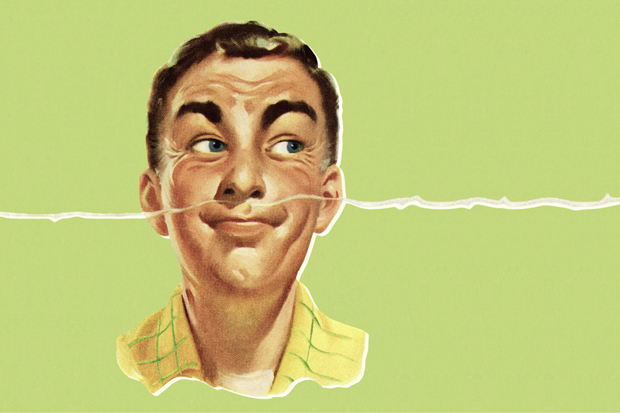

A greedy variation of this approach is called Greedy Best First Search (`greedy_best_first_search`in our code base). It uses only $h(n)$ as the prioiry.

#### Heuristic Functions

Heuristic functions are an important element of any heuristic search, and A* in particular.

Effective heuristics possess certain characteristics that enable the algorithm to efficiently find solutions while minimizing the search effort.

Here are some key characteristics of heuristic functions:

* **Safeness**: a heuristic function is safe if for all nodes $n$, if $h(n)=∞$ then the actual cost from $n$ to the goal, denoted $h^*(n)$ is $∞$.

* **Goal Awareness:** a heuristc is goal-aware if for all goal nodes $h(n)=0$.

* **Admissibility**: A heuristic function is admissible if for all nodes
$n$, the estimated cost to goal $ℎ(𝑛)$ is less than or equal to the actual cost to reach a goal state from node $𝑛$ (i.e., it under-estimates the cost to goal).
Note that when we are searching for a node that maximizes some value (e.g., using Best-First-Search), a heuristic is admissible if it over-estimates the value.

* **Consistency** : A heuristic function is consistent if the estimated cost to reach the goal from any given node is always less than or equal to the sum of the cost to reach its neighboring node plus the estimated cost from the neighboring node to the goal. Formally, for any node $𝑛$ and its successor node $𝑛'$, the following inequality holds:
$ ℎ(𝑛)\leq 𝑐(𝑛,𝑛')+ℎ(𝑛')$ where $𝑐(𝑛,𝑛')$ is the cost of the edge between $𝑛$ and $𝑛′$.

* **Efficiency**: While not a strict requirement, heuristic functions that efficiently guide a search towards the goal can significantly improve performance. Efficient heuristics should accurately estimate the remaining cost to the goal while minimizing computational overhead.







The above characteristics have various effects on the search. For example, admissible heuristics ensure that A* will find an optimal solution, i.e., a minimum-cost path from the start node to a goal node. Consistent heuristics guarantee that the first time a node is expanded, it's with  minimal cost.

❓ **What does this mean in terms of the closed list?**

Let's run A* for our problem, using the goal heuristic. This is a very simple heuristic that assigns a value of $1$ to any node that is not a goal node, and $0$ otherwise

❓ **What are the characteristics of this heuristic?**.

In [ ]:
from aidm.search.best_first_search import a_star

In [ ]:
from aidm.search.heuristic import goal_heuristic

In [ ]:
[best_node, best_plan, resources] = a_star(problem=problem,heuristic_func=goal_heuristic, use_closed_list=True)

In [ ]:
print_results(info='a_star with goal heuristic', node=best_node, plan=best_plan, resources=resources)


Note that even with this very simple heuristic, we reduced the number of expanded nodes when compared to Breadth First Search. However, we can do much better than that.

⚒ **Task 1**: Implement a heuristic method for our problem. Try to maximize efficiency.



To help you get started, we provide ```def your_heuristic(node,problem)``` below that accepts as input the node and the problem. Our very unclever implementation ignores these values by setting a fixed value of $0$. Change the code to a more efficient heuristic. We provide some ideas and pointers below.

In [ ]:
def your_heuristic(node,problem):
  # your code goes here
  return 0

**Some hopefully useful hints:**

The fields of a node (defined [here](https://github.com/CLAIR-LAB-TECHNION/aidm/blob/main/aidm/search/node.py)) are the following:
        
```
self.state = state
self.parent = parent
self.action = action
self.value = value
self.depth = 0
```



The problem we are using here is of type PDDLProblem, and is defined [here](https://github.com/CLAIR-LAB-TECHNION/aidm/blob/main/aidm/environments/pddl/pddl_problem.py)

To get the literals (predicated, facts) that are true, you can run the following:



```
current_state_literals = node.state.content.literals

```



To get the goal literals, you can run the following:

    
```
goal_state_literals = problem.env.problems[0].goal.literals

```



For your convenience, we implemented a relaxed version of the problem, in which delete effects are ignored, meaning only the positive (add) effects are considered. This can be used to implement the delete-relaxation heuristic (Bonet and Geffner 2001), which solves the relaxed problem to get a heuristic value of a node.


The relaxed problem can be obtained as follows.



```
relaxed_problem = problem.get_relaxed_problem()
```



You can set the initial state as follows.



```
relaxed_problem.set_initial_state(node.state)
```



Let's run the search with the new heuristic

In [ ]:
[best_node, best_plan, resources] = a_star(problem=problem,heuristic_func=your_heuristic, use_closed_list=True)

Finally, let's examine its performance.

In [ ]:
print_results(info='a_star with your heuristic', node=best_node, plan=best_plan, resources=resources)

**Is your heuristic goal-aware? admissible? consistent? safe? efficient ?**

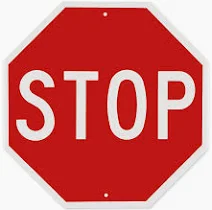

Below we give a possible solution. Don't let us spoil your fun.



# Possible Solutions

In [ ]:
def our_heuristic(node, problem):
    #get current state literals
    current_state_literals = node.state.content.literals
    #get goal literals
    goal_state_literals = problem.env.problems[0].goal.literals
    #check difference
    count = len(goal_state_literals)
    for literal in goal_state_literals:
        if literal in  current_state_literals:
            count -=1
    return count

In [ ]:
[best_node, best_plan, resources] = a_star(problem=problem,heuristic_func=our_heuristic, use_closed_list=True)

In [ ]:
print_results(info='a_star with our heuristic', node=best_node, plan=best_plan, resources=resources)

Let's try another approach. Here, we exploit the relaxed version of the problem but use Breadth-First Search to find a solution. In the original delete-relaxation approach by Bonet and Geffner 2001, all applicable actions are applied in parallel.

In [ ]:
def our_heuristic2(node, problem):
    relaxed_problem = problem.get_relaxed_problem()
    relaxed_problem.set_initial_state(node.state)
    [best_node, best_plan, resources] = breadth_first_search(relaxed_problem, logging=False)
    if best_plan is None:
        return np.inf
    return len(best_plan)

In [ ]:
[best_node, best_plan, resources] = a_star(problem=problem,heuristic_func=our_heuristic2, use_closed_list=True)

❓ How did you do? Was your approach able to open fewer nodes? Did it take less time?

Note that some heuristics might reduce the number of explored nodes, but may be expensive to compute, and vice-versa. This trade-off between an informative heuristic and one that is easier to compute is at the heart of planning research.

Let's try a different approach using the relaxed problem, but without performing a full search at each node. Instead, we will apply all possible actions in the relaxed problem continuously until we reach a goal state. This heuristic should be quicker to compute, as it simplifies the process by avoiding exhaustive searches and focusing on direct action application to progress towards the goal.

In [ ]:
def our_heuristic3(node, problem):
    relaxed_problem = problem.get_relaxed_problem()
    relaxed_problem.set_initial_state(node.state)

    n_iter = 0
    current_state = node.state
    while not relaxed_problem.is_goal_state(current_state):
        n_iter +=1
        # apply all actions:
        actions = relaxed_problem.get_applicable_actions(current_state)
        for a in actions:
            current_state = relaxed_problem.apply_action(a)

    return n_iter



In [ ]:
[best_node, best_plan, resources] = a_star(problem=problem,heuristic_func=our_heuristic3, use_closed_list=True)

In [ ]:
print_results(info='a_star with our heuristic', node=best_node, plan=best_plan, resources=resources)

We can clearly see that this approach falls in the middle between a simple naive heuristic and the relaxed heuristic with a full search at each node, both in terms of time and the number of iterations required. By applying all possible actions in the relaxed problem until reaching a goal state, we strike a balance between computational efficiency and solution quality.

⚒ **Task 1.1**: : compare heuristic for harder problem
To better understand the effectiveness of different heuristics, let's compare them using a more complex problem. Generate a more challenging PDDL problem within our domain that requires multiple stacking and unstacking actions. Then, run a search using three different heuristics and analyze their performance.

* Generate a harder PDDL problem:
Design a problem that necessitates multiple stacking and unstacking actions.

* Run a search with the different heuristics and cmpare their performance

In [ ]:
### Your code here, use as much cells as you want.

# Extending NTBW

In the basic PDDL formulation of our NTBW setting preseneted above, the task is to achieve a configuration of labeled blocks on specific tables.
❓ What are apsects of the problem that were ignored in this formulation?



In a more advanced (and perhaps more realistic) version of NTBW, one may require an optimal plan to achieve a configuration of blocks of certain colors (e.g., two yellow blocks on top of a blue block) while being agnostic as to which blocks are used. This requires reasoning at a higher level of abstraction, highlighting even further the need to combine task and motion planning.

In addition to the need to find feasible motions that achieve the high-level action, we should also start thinking about the kind of low-level information that needs to be somehow reflected in the high-level representation of the problem.
For Example, in the image of our NTBW setting above, picking up a yellow block from each table achieves the same 'predicate' of a yellow block being graspped by the gripper - but these actions have very different costs, and possibly risks, associated with them. How do we capture this in the high-level plans?

We don't need to give a complete answer to this yet, but it would be great to start thinking about this as we progress with the tutorials.

⚒ **Task 2**:


1.  Try to capture some of the complexities that would occur in a real-world NTBW
that are not captured in the PDDL model we gave above.

2.  As another challenge, can you think of a representation that will allow specifying that there should be a set of blocks with specified colors, instead of referring to labeled blocks (e.g., yellow and red block on table 3)?

In [ ]:
DOMAIN_EXTENDED = """"#your code here

In [ ]:
PROBLEM_EXTENDED = """"#your code here

You can create an extended version of the problem and run it as follows.

Unfortunately, our codebase does not support many very important PDDL features that you might have used. If this is the case, try running your PDDL on one of the great online solvers available, including:

* Planning.domains (editor and online planning engine): https://editor.planning.domains/
* FD online (editor and online planning engine): https://lcas.lincoln.ac.uk/fast-downward/
* Visual Studio PDDL plugin: https://marketplace.visualstudio.com/items?itemName=jan-dolejsi.pddl

In [ ]:
extended_problem = PDDLProblem(domain=DOMAIN_EXTENDED, problem=PROBLEM_EXTENDED)

In [ ]:
[best_node, best_plan, resources] = a_star(problem=extended_problem,heuristic_func=our_heuristic, use_closed_list=True)

In [ ]:
print_results(info='a_star with our heuristic', node=best_node, plan=best_plan, resources=resources)

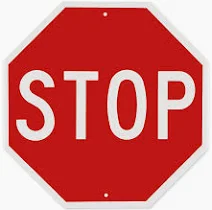

Below we give a possible solution. Don't let us spoil your fun.



# Possible Solutions

The following solution provides a way to get a block on a table. Note that this is not a solid solution. In this version, if the relevant block is picked up, the value of the predicate is not updated.

In [ ]:
DOMAIN_EXTENDED = """
(define (domain n-table-blocks-world)
  (:requirements :strips :typing :equality)
  (:types block color table)
  (:predicates (on ?b1 ?b2 - block)
	           (ontable ?b - block ?t - table)
	           (clear ?b - block)
	           (handempty)
	           (holding ?b - block)
	           (bcolor ?b - block ?c - color)
               (colorontable ?c - color ?t - table)
               (goal-achieved)
               (robot_at ?t - table)
 )

(:constants
 Y B G R P - color
 T1 T2 T3 - table
)


  (:action achieve-goal
       :parameters (?b - block)
	     :precondition (and (colorontable Y T1)(bcolor ?b Y))
	     :effect
	     (and (goal-achieved)
		   ))

  (:action pick-up
	     :parameters (?b - block ?t - table)
	     :precondition (and (clear ?b)(ontable ?b ?t)(handempty))
	     :effect
	     (and
       (not (ontable ?b ?t))
		   (not (clear ?b))
		   (not (handempty))
		   (holding ?b))
       )

  (:action put-down
	     :parameters (?b - block ?t - table ?c - color)
	     :precondition (holding ?b)
	     :effect
	     (and (not (holding ?b))
		   (clear ?b)
		   (handempty)
		   (ontable ?b ?t)
       (colorontable ?c ?t))
    )

  (:action stack
	     :parameters (?b1 ?b2 - block)
	     :precondition (and (holding ?b1) (clear ?b2))
	     :effect
	     (and (not (holding ?b1))
		   (not (clear ?b2))
		   (clear ?b1)
		   (handempty)
		   (on ?b1 ?b2)
       )
    )

  (:action unstack
	     :parameters (?b1 ?b2 - block)
	     :precondition (and (on ?b1 ?b2) (clear ?b1)(handempty))
	     :effect
	     (and (holding ?b1)
		   (clear ?b2)
		   (not (clear ?b1))
		   (not (handempty))
		   (not (on ?b1 ?b2)))
     )
 )

"""

In [ ]:
PROBLEM_EXTENDED = """
(define (problem 3t5b)
(:domain n-table-blocks-world)
(:objects
B1 B2 B3 B4 B5 - block
)
(:init
(handempty)

(ontable B1 T1)
(clear B1)
(bcolor B1 Y)

(ontable B2 T1)
(clear B2)
(bcolor B2 B)

(ontable B3 T2)
(clear B3)
(bcolor B3 Y)

(ontable B4 T3)
(clear B4)
(bcolor B4 G)

(ontable B5 T3)
(clear B5)
(bcolor B5 R)

)
(:goal (and
(goal-achieved)
))
)

"""

Let's add action costs.

In [ ]:
DOMAIN_EXTENDED = """
  (define (domain n-table-blocks-world)
  (:requirements :strips :typing :equality)
  (:types block color table)
  (:predicates (on ?b1 ?b2 - block)
	           (ontable ?b - block ?t - table)
	           (clear ?b - block)
	           (handempty)
	           (holding ?b - block)
	           (bcolor ?b - block ?c - color)
               (colorontable ?c - color ?t - table)
               (goal-achieved)
               (robot_at ?t - table)
 )

(:constants
 Y B G R P - color
 T1 T2 T3 - table
)

  (:functions
  (total-cost)
 )

  (:action achieve-goal
       :parameters (?b - block)
	     :precondition (and (colorontable Y T1)(bcolor ?b Y))
	     :effect
	     (and (goal-achieved)
		   ))

  (:action pick-up
	     :parameters (?b - block ?t - table)
	     :precondition (and (clear ?b)(ontable ?b ?t)(handempty))
	     :effect
	     (and
       (not (ontable ?b ?t))
		   (not (clear ?b))
		   (not (handempty))
		   (holding ?b)
           (increase (total-cost) 8)
          )
       )

  (:action put-down
	     :parameters (?b - block ?t - table ?c - color)
	     :precondition (holding ?b)
	     :effect
	     (and (not (holding ?b))
		   (clear ?b)
		   (handempty)
		   (ontable ?b ?t)
           (bcolor ?b ?c)
           (colorontable ?c ?t)
           (increase (total-cost) 5)
              )
    )

  (:action stack
	     :parameters (?b1 ?b2 - block)
	     :precondition (and (holding ?b1) (clear ?b2))
	     :effect
	     (and (not (holding ?b1))
		   (not (clear ?b2))
		   (clear ?b1)
		   (handempty)
		   (on ?b1 ?b2)
           (increase (total-cost) 5)

       )
    )

  (:action unstack
	     :parameters (?b1 ?b2 - block)
	     :precondition (and (on ?b1 ?b2) (clear ?b1)(handempty))
	     :effect
	     (and (holding ?b1)
		   (clear ?b2)
		   (not (clear ?b1))
		   (not (handempty))
		   (not (on ?b1 ?b2))
           (increase (total-cost) 5)
              )
     )
 )
"""

In [ ]:
PROBLEM_EXTENDED = """
(define (problem 3t5b)
(:domain n-table-blocks-world)
(:objects
B1 B2 B3 B4 B5 - block
)

(:init
(handempty)

(ontable B1 T1)
(clear B1)
(bcolor B1 Y)

(ontable B2 T1)
(clear B2)
(bcolor B2 B)

(ontable B3 T2)
(clear B3)
(bcolor B3 Y)

(ontable B4 T3)
(clear B4)
(bcolor B4 G)

(ontable B5 T3)
(clear B5)
(bcolor B5 R)

(= (total-cost) 0)

)
(:goal (and
(goal-achieved)
))
(:metric minimize (total-cost))
)
"""


In the formulation above, action costs are uniform. However, actual costs are not at all uniform (and loyally estimating them is part of what makes integrated task and motion planning challenging). Let's try a formulation that accounts for varying action costs.

In [ ]:
DOMAIN_EXTENDED = """
(define (domain n-table-blocks-world)
  (:requirements :strips :typing :equality :action-costs)
  (:types block color table)
  (:predicates (on ?b1 ?b2 - block)
	           (ontable ?b - block ?t - table)
	           (clear ?b - block)
	           (handempty)
	           (holding ?b - block)
	           (bcolor ?b - block ?c - color)
               (colorontable ?c - color ?t - table)
               (goal-achieved)
               (at ?t - table)
 )

(:constants
 Y B G R P - color
)

  (:functions
  (total-cost) - number
  (table-distance ?t1 ?t2 - table) - number
  )

  (:action achieve-goal
       :parameters (?b - block)
	     :precondition (and (colorontable Y T1)(bcolor ?b Y))
	     :effect
	     (and (goal-achieved)
		   ))

  (:action pick-up
	     :parameters (?b - block ?t - table)
	     :precondition (and (clear ?b)(ontable ?b ?t)(handempty)(at ?t))
	     :effect
	     (and
       (not (ontable ?b ?t))
		   (not (clear ?b))
		   (not (handempty))
		   (holding ?b)
           (increase (total-cost) 8)
          )
       )

  (:action put-down
	     :parameters (?b - block ?t - table ?c - color)
	     :precondition (and(holding ?b)(at ?t))
	     :effect
	     (and (not (holding ?b))
		   (clear ?b)
		   (handempty)
		   (ontable ?b ?t)
           (bcolor ?b ?c)
           (colorontable ?c ?t)
           (increase (total-cost) 5)
              )
    )

  (:action stack
	     :parameters (?b1 ?b2 - block)
	     :precondition (and (holding ?b1) (clear ?b2))
	     :effect
	     (and (not (holding ?b1))
		   (not (clear ?b2))
		   (clear ?b1)
		   (handempty)
		   (on ?b1 ?b2)
           (increase (total-cost) 5)

       )
    )

  (:action unstack
	     :parameters (?b1 ?b2 - block)
	     :precondition (and (on ?b1 ?b2) (clear ?b1)(handempty))
	     :effect
	     (and (holding ?b1)
		   (clear ?b2)
		   (not (clear ?b1))
		   (not (handempty))
		   (not (on ?b1 ?b2))
           (increase (total-cost) 5)
              )
     )

  (:action move
	     :parameters (?t1 ?t2 - table)
	     :precondition (and (at ?t1))
	     :effect
	     (and
           (not (at ?t1))
		   (at ?t2)
           (increase (total-cost)(table-distance ?t1 ?t2) )
          )
     )

  )

"""

In [ ]:
PROBLEM_EXTENDED = """
(define (problem prob)
(:domain n-table-blocks-world)
(:objects
B1 B2 B3 B4 B5 - block
 T1 T2 T3 - table
)

(:init
(handempty)

(at T1)

(ontable B1 T1)
(clear B1)
(bcolor B1 Y)

(ontable B2 T1)
(clear B2)
(bcolor B2 B)

(ontable B3 T2)
(clear B3)
(bcolor B3 Y)

(ontable B4 T3)
(clear B4)
(bcolor B4 G)

(ontable B5 T3)
(clear B5)
(bcolor B5 R)

(= (total-cost) 0)
(= (table-distance T1 T2) 1)
(= (table-distance T1 T3) 1)
(= (table-distance T2 T3) 2)
(= (table-distance T2 T1) 2)
(= (table-distance T3 T1) 3)
(= (table-distance T3 T2) 3)
(= (table-distance T1 T1) 0)
(= (table-distance T2 T2) 0)
(= (table-distance T3 T3) 0)

)
(:goal (and
(goal-achieved)
))
(:metric minimize (total-cost))
)
"""


Note that the formulation above will not run for all planners. Use
[this](https://editor.planning.domains/#read_session=pVW7ajuFCW) solver, developed by Christian Muise. Select the BWFS planner.

❓ Are we done? Is there a way to account for the other complexities?

# NTBW in the real(istic) world

So far, we used a high-level abstraction of the NTBW setting. For example, we used a 'pick-up red block' action which we could apply (deterministically) and use the outcome for further exploring our state space.


In order to use the plans generated by the abstract representation, we need to understand how they relate to a real robotic setting. This means we can't simply assume a pick-up action will be *executed* as expected, we need to **ground** the representation within the setting of interest.

Note that the grounding here is related to but different from the grounding we do to PDDL elements. In PDDL, grounding is the process of converting a domain and problem description into a fully instantiated representation, where all variables, objects, predicates, and actions are explicitly defined. For example, we take the action 'pick-up (?b - block ?t - table)' and ground it to block B2 and table T3 from our problem description, resulting in the grounded action 'pick-up (B2,T3)'

In robotics, grounding high-level actions to actions that can be performed in the real-world (or simulated) setting involves translating abstract actions into concrete low-level commands or motions that the robot's actuators can execute. This process is crucial for enabling robots to autonomously perform tasks specified at a higher level, such as manipulation, navigation, or interaction with the environment. In order to understand this, we need to know a little more about robots.

## What's a robot?

![agent-env.png](https://raw.githubusercontent.com/CLAIR-LAB-TECHNION/ICAPS-24/main/assets/figures/agent-env.png)


We can't, of course, give you a simple and widely-acceptable definition, so we won't even try. We can say that a robotic agent typically consists of several components that work together to perceive, reason, and act in the environment. We therefore generally describe a robot as an agent with three main components:

* **Perception:** the process of interpreting sensor data to understand the robot's environment. Robots use various sensors to perceive the environment, including cameras, depth sensors, and possibly tactile sensors for touching and grasping objects. These sensors provide information about the current state of the environment, including the positions of the agent and of objects in its environment. Perception may involve different tasks such as object detection and recognition, scene understanding, localization (determining the robot's position), mapping (building a representation of the environment), and sensor fusion (integrating data from multiple sensors to obtain a coherent perception of the environment).


* **Actuation:** Actuators are the physical components responsible for executing the actions by translating control commands into physical motion. The robot needs actuators to manipulate objects in the environment. This might include robotic arms with grippers or other end-effectors capable of picking up, moving, and placing blocks. At a lower level, actuators include motors, servos, pneumatic actuators, and hydraulic actuators. Actuators allow the robot to perform physical actions such as moving its limbs, grasping objects, or locomoting through its environment.


* **Control:** The control system is responsible for processing sensory input and generating appropriate actions for the robot to take, i.e., generating commands to actuate the robot's actuators (e.g., motors, joints), ensuring that it interacts with its environment in desired ways.
One aspect of control can involve high-level reasoning such as task planning (generating a sequence of actions to achieve a goal), path planning (finding a collision-free path from the robot's current position to a desired position), and decision-making under uncertainty (making decisions in situations with incomplete or uncertain information). Another aspect involves low-level control tasks such as trajectory generation, feedback control (adjusting the robot's actions based on sensor feedback), and motion execution.


Naturally, our focus here is on the control component since we are interested in planning and decision-making.
Traditionally, most robots were not equipped with reasoning capabilities, and their behaviors (i.e., policies) were mostly predetermined and fixed.

There are two main paradigms for enabling autonomy to robotic agents, each with its advantages, limitations, and applications.

Model-based approaches rely on mathematical models that describe the physical dynamics of the robot and its environment. These models are derived from principles of physics and mechanics and typically involve equations that govern the robot's motion, dynamics, and interactions.

While these approaches typically provide a clear understanding of how the robot behaves and interacts with its environment and generalize well to new scenarios and environments that adhere to the same physical principles, they are sensitive to modeling errors and inaccuracies in the underlying models. Moreover, developing and solving complex physics-based models can be computationally intensive, especially for systems with high degrees of freedom or non-linear dynamics.


In contrast, data-driven approaches rely on machine learning techniques to learn patterns and relationships directly from data collected by the robot's sensors. This can involve supervised learning (learning from labeled data), unsupervised learning (learning from unlabeled data), or reinforcement learning (learning from interaction with the environment).

Many modern robotic agents are equipped with learning capabilities that allow them to improve their performance over time through experience. This allows them to act in and adapt to complex environments for which dynamics are hard to model. On the other hand, most data-driven approaches require large amounts of high-quality training data to learn accurate models, which may be challenging to collect for robotic settings. In addition, policies generated by data-driven approaches struggle to generalize to new or unseen scenarios and can be difficult to interpret and understand due to their complex and opaque nature.

### Planning for robots

Our focus here is on using planning for the control of robotic agents. In order to use the plans generated by the abstract representations we have been using above, we need to understand how they relate to a real robotic setting. This means we can't simply assume a pick-up action will happen as expected, we need to ground it within the setting of interest and translate it into a sequence of motions that are achievable in the physical setting and that achieve the desired goal.




For example, let's see what we need to consider if we want our robot to perform the action **'pick-up (B2,T3)'**.

In our example, picking up a block that is in a stable position on a surface involves bringing the robot to a position, known in robotics as a **configuration**, from which if the gripper is closed, the block is caught between its two fingers without slipping. This may sound easy, but it's not that simple.

First, we need to compute a configuration from which a grasp should be performed. This depends on the robot's capabilities (which configurations can it reach"), on the object being manipulated (is it rigid or deformable?), and on the ability to sense the environment and accurately estimate the current state.



In our example, this involves:

* Detecting the position of table T3.
* Detecting the position of B2. If there are several blocks on T3, but each with a unique color, and the robot has an RGB camera, it might be sufficient to look for 'blue'. However, if we have multiple blue blocks, we would need to monitor the position of each object.
*  Finding a good grasp configuration from which to attempt a grasp, i.e. from which to close the gripper. If we fail, we might move the object (or even drop it).
* Finding a way to get the robot safely from its current configuration to the chosen grasp configuration (typically referred to as motion planning).


Planning for robots involves continuously analyzing the current state of the environment, determining which actions are possible, and selecting an appropriate sequence of actions that will achieve the goal.

Another complication that arises when planning for robots is the fact that they often act in highly uncertain environments and challenges such as sensor noise, uncertainty in perception, variability in object properties, and the complexity of robot manipulation need to be addressed. Thus, even after a plan has been selected, there is a need to process incoming sensory information and control and monitor the robot's actuators to perform the intended actions.
This often involves combining algorithms for perception, planning, and control, as well as careful integration of hardware and software components to ensure reliable operation. Also, if the robot fails to execute its prescribed actions or encounters unexpected obstacles or changes in the environment, it may need to adapt its plan on the fly to achieve the goal despite the new circumstances.

There are of course many other factors that need to be considered, such as safety, communication, and interaction with other agents and with humans, and many more which we can't cover here, but we encourage you to explore.


## Why we need TAMP - revisited

Hopefully, by now we have convinced you that planning for robots is hard (and fascinating!). It's hard even if we simply want it to pick up a single object. Things become more complicated if we want it to do more complex tasks, such as multi-step assembly tasks,  multi-destination navigation tasks, autonomous driving, and more.

All these settings require combining reasoning with high-level symbolic task representations (e.g., pick-and-place, assembly, navigation) and with representations of low-level physical motions (e.g., grasping, moving, manipulating objects).


On the one hand, task planning alone may not capture important physical constraints or feasibility considerations that are crucial for successful execution. By integrating motion planning into the planning process, it is possible to ensure that task-level plans are physically realizable and satisfy constraints such as collision avoidance, kinematic limits, and environmental constraints.

On the other hand, while motion planning is crucial for determining how a robot moves through its environment, it cannot capture high-level reasoning aspects that may be required for accomplishing a high-level objective. Motion planning focuses on generating collision-free paths or trajectories for the robot to follow, but it does not address the higher-level objectives or goals of the task. Moreover, complex tasks often involve multiple subtasks, temporal constraints, and task dependencies that cannot be captured solely through motion planning. After generating motion plans, robots need to monitor the execution of tasks to ensure they are carried out successfully. This may involve detecting and handling failures, replanning in response to changes or failures, and coordinating the execution of concurrent tasks, which goes beyond the scope of motion planning.


Combining task and motion planning enables robots to solve these tasks in an integrated manner, considering both task-level objectives and physical constraints.


# What have we done and what comes next ?

In this tutorial, we have used task planning to solve a high-level task and hopefully convinced you that there is a need to combine task planning with motion planning that accounts for what is feasible in the physical environment.

While it could have been great to work with an actual robot in a real-world setting, we will have to make do with a simulated setting using the MuJoCo simulator. [MuJoCo](https://mujoco.org/) (short for "Multi-Joint dynamics with Contact") is a physics engine often used in robotics, biomechanics, graphics, and machine learning research. MuJoCo provides a simulation environment where users can define articulated bodies (like robots or humanoids), specify their physical properties (such as mass, friction, and inertia), and simulate their behavior under various conditions. It accurately models contact interactions between bodies, which is crucial for tasks like robotic manipulation, locomotion, and object interaction.

Our MuJoCo version of the MTBW setting is depicted below  








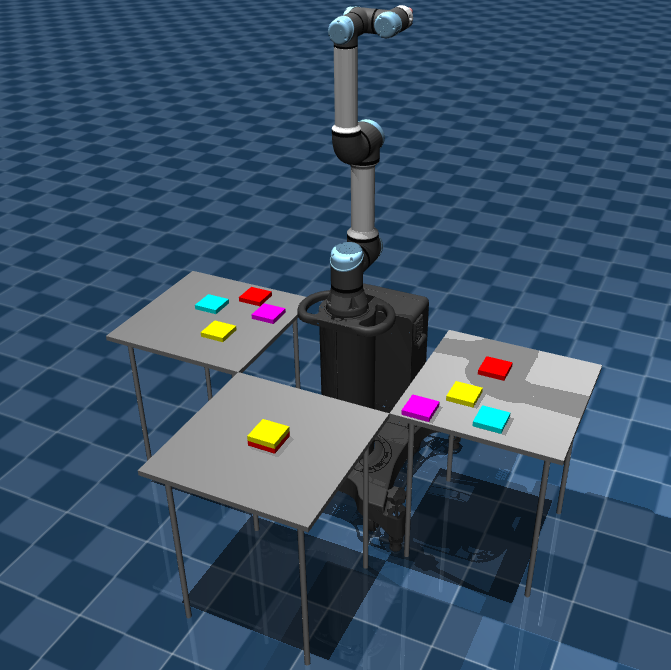*


In our next tutorial, we will:
  * provide a brief introduction to motion planning
  * demonstrate kinematics (which deals with describing the motion of robot manipulators, such as robotic arms, based on their joint positions and velocities) and inverse kinematics (which involves determining the joint configurations of a robotic manipulator that will achieve a desired end-effector position and orientation).  
  * discuss how to account for continuous state space
  * see that there are typically multiple (and even infinite) ways to move and solve a task


# Extra: Using Q-learning to find a plan

We can also try other approaches. For example, we can use a method called q-learning, which is a reinforcement learning algorithm. As opposed to the model-based approaches above that relied on a model of the environment to search the state space, q-learning is a model-free approach, meaning it learns from interactions with the environment (here, implemented using a PDDL representation) by updating estimates of the quality of actions based on observed rewards.

At its core, Q-learning is based on the concept of a Q-table, which stores the Q-value, representing the expected cumulative reward for taking each action in every possible state. The algorithm iteratively updates the Q-values as it explores the environment.

Formally, each state is $s$ and action $a$ is associated with a Q-value $Q(s,a)$

$Q(s,a)\leftarrow Q(s,a)+α(r+γmax_{a′}Q(s′,a′ )−Q(s,a))$

Where:

$𝑄(𝑠,𝑎)$ is the Q-value of state-action pair $(𝑠,𝑎)$, $𝑟$ is the reward received after taking action $𝑎$ in state $s$, $𝑠′$ is the next state, $\alpha$ is the learning rate (a parameter determining the impact of new information) and $\gamma$ is the discount factor (a parameter balancing immediate and future rewards).

Q-learning is widely used in various applications, including robotics, gaming, recommendation systems, and autonomous vehicles, where agents must learn optimal strategies through trial and error. It's a foundational algorithm in the field of reinforcement learning and forms the basis for more advanced techniques like Deep Q-Networks (DQN).

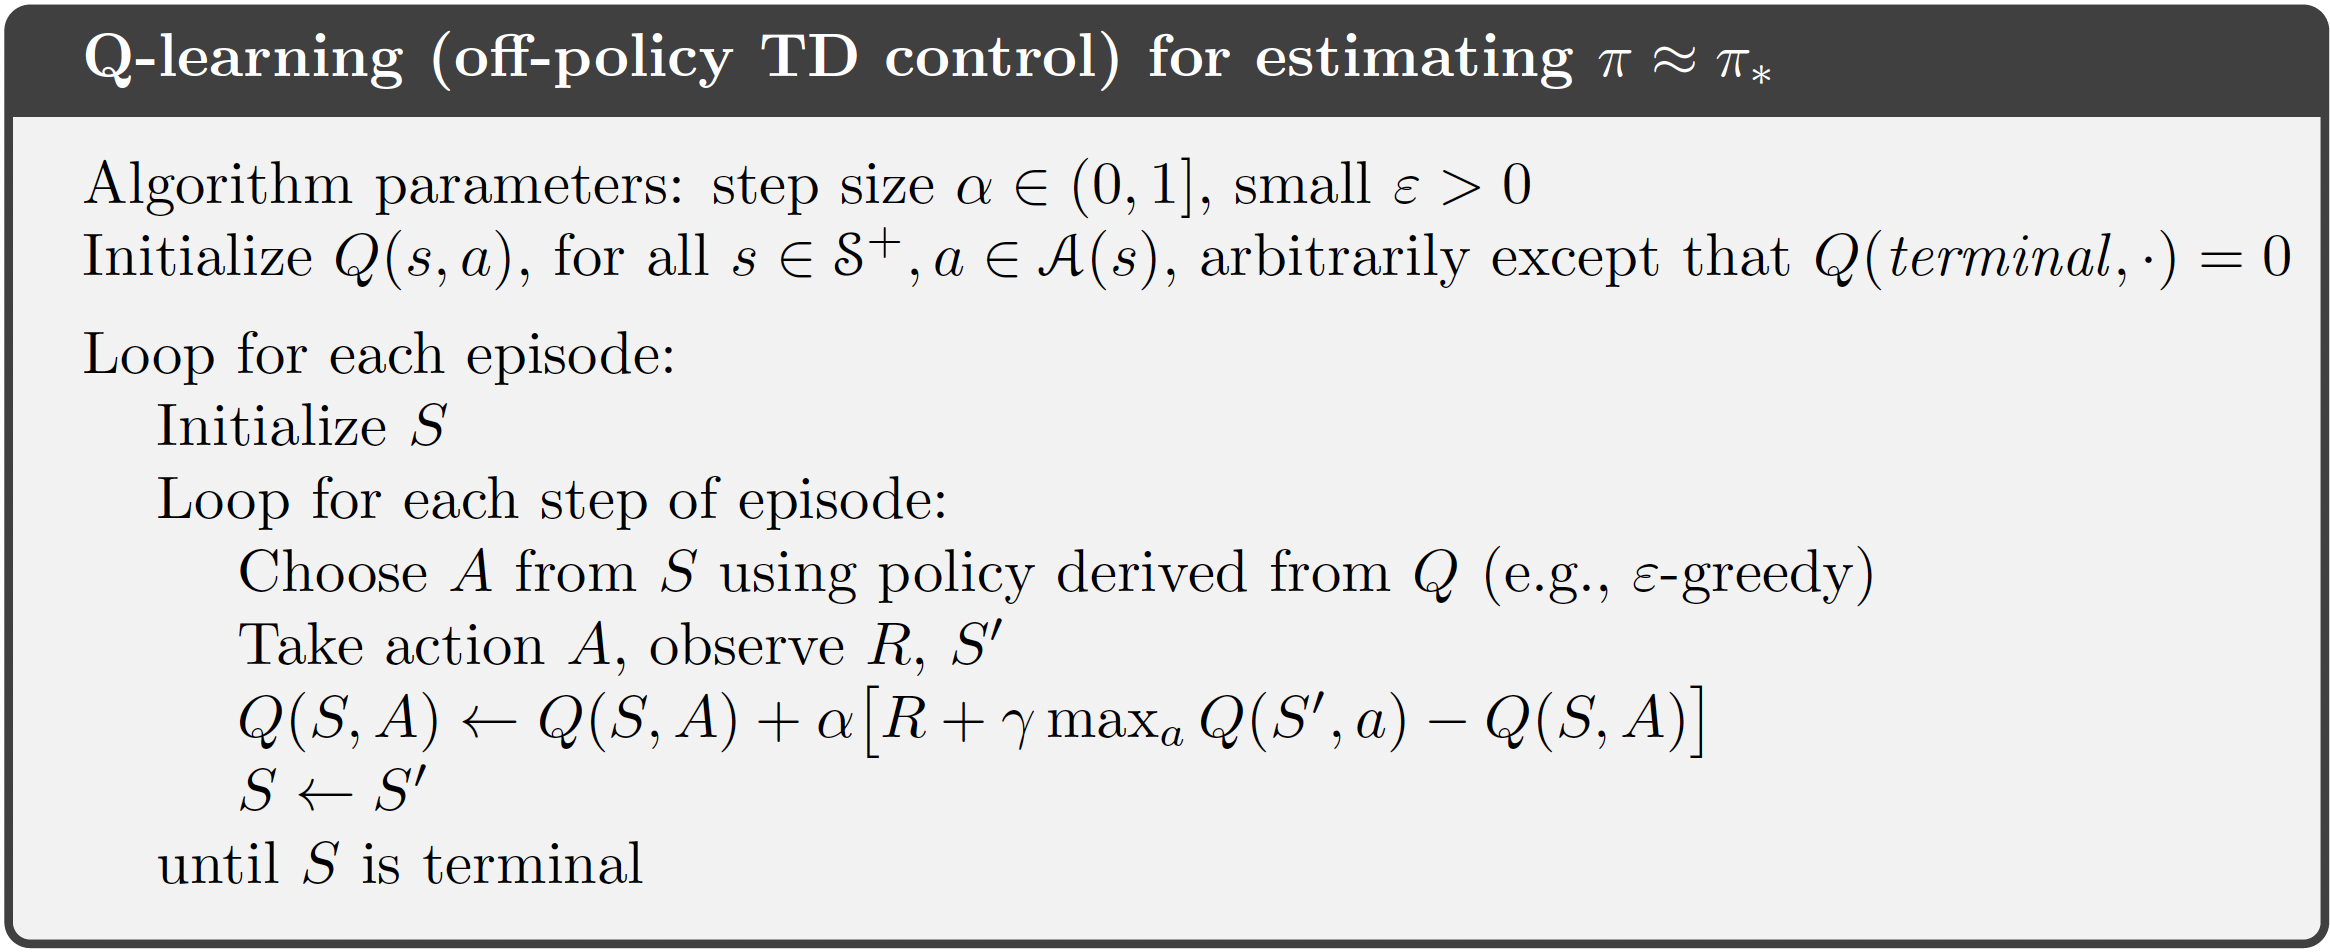

The pseudo-code in the image describes the Q-learning algorithm as in [Reinforcement Learning - an Introduction (second edition) by Richard S. Sutton and Andrew G. Barto](https://mitpress.mit.edu/9780262039246/reinforcement-learning/):
- The agent maintains a Q-table that stores the expected future reward for taking an action in a given state.
- It interacts with the environment:
- Chooses an action (explore vs. exploit using epsilon-greedy).
- Takes the action, receives a reward, and observes the next state.
- Updates the Q-value for the previous state-action pair using the reward and the best future reward from the new state (TD learning).
- Repeats, learning the best actions to take in each state for long-term reward.

If you are interested in the relationship between planning and RL we recommend [this](https://www.youtube.com/watch?v=45FKxa3qPHo) video by Michael Littman.

### Training Example

Let's train a vanilla Q-learning agent to solve an NTBW problem. We first initialize the agent with the appropriate hyperparameters. In this case, with learning rate ($\alpha$) 0.9 and discount factor ($\gamma$) 0.99.

In [ ]:
from aidm.rl.q_learning import QLearning
qlearning = QLearning(learning_rate=0.9, discount_factor=0.99)

In Q-learning, we interact with an environment, not a model. A common API for environments is the [gymnasium API](https://github.com/Farama-Foundation/Gymnasium). Coincidentally, the underlying PDDL parser in our `problem` object is actually a gymnasium environment.

In [ ]:
env = problem.env

We will now begin training. With every step, we update the q-table according to the update step defined above. Every few episodes we will evaluate our agent's performance. After training we receive the performance history which allows us to analyze training.

In [ ]:
import random
random.seed(42)  # set random seed to avoid changing results for the purpose of demonstration

history = qlearning.train(env, num_episodes=2500, max_steps_per_episode=50, eval_every=100, eval_kwargs=dict(pbar=False))
history

Notice how the agent's performance fluctuates. Even though it achieves optimal performance around the middle of training, it "forgets" how to solve the problem before "remembering" again. This is a result of a learning rate that is too high. We are able to find this issue thanks to the performance history.

For the purpose of this demonstration, we are not required to fix the hyperparameters and retrain. The agent will consistently achieve maximum (discounted) reward on the single problem described in PDDL. Let's evaluate the agent's performance to verify this.

In [ ]:
qlearning.evaluate(env, aggregate_episode_rewards=True)

We cannot be certain that this is the highest possible value the agent can acieve without disecting the problem and finding the optimal solution. Moreover, due to the high learning rate, we are all but certain that the q-table does not represent the true action value function. However, we will show below that our agent solves the problem optimally.

### A Step-by-step Breakdown

Let's solve the problem step-by-step. We start with B2 on B1, and we want B3 to be on B1. As a human with general reasoning capabilities, we can deduce that the optimal course of action is: unstack B2 from B1, put down B2 anywhere, pick up B3, and stack B3 on B1. Let's see if our agent's Q-table leads him it to the same conclusion.

First, let's extract a policy from our agent, that is, a function that receives the current state and outputs the action to take

In [ ]:
policy = qlearning.to_policy(env)

Let's reset the environment to the problem's initial state.

In [ ]:
s, info = env.reset()
s.literals

This is the expected initial state. Let's see what actions are valid from this state.

In [ ]:
env.action_space.all_ground_literals(s)

Now let's see how the agent's Q-table values the different actions from this state.

In [ ]:
q = qlearning.q_table
q[s]

As expected, the estimated Q-value for the expected action, unstack B2 from B1, much higher than all other actions. Thus, this is the action our policy will choose.

In [ ]:
a = policy(s)
a

Let's perform this action now.

In [ ]:
s, r, term, trunc, info = env.step(a)
print(f'task complete: {term or trunc}')
print(f'received reward: {r}')
print('new state:')
s.literals

We have taken our first step and everything is going according to what we expected. Let's continue this for three more steps.

In [ ]:
q[s]

The Q-table's highest value for this state is to stack B2 on B5. It doesn't matter where we put B2 because it is not a part of the goal. All that matters is that B1 is now clear. Throughout the agent's exploration, it chose to do this by stacking B2 on an irrelevant block.

In [ ]:
a = policy(s)
a

After the next step the agent's gripper (hand) will be free to pick up the next block

In [ ]:
s, r, term, trunc, info = env.step(a)
print(f'task complete: {term or trunc}')
print(f'received reward: {r}')
print('new state:')
s.literals

We now expect our agent to pick up B3.

In [ ]:
q[s]

In [ ]:
a = policy(s)
a

In [ ]:
s, r, term, trunc, info = env.step(a)
print(f'task complete: {term or trunc}')
print(f'received reward: {r}')
print('new state:')
s.literals

Finally, we want to stack B3 on B1.

In [ ]:
q[s]

In [ ]:
a = policy(s)
a

In [ ]:
s, r, term, trunc, info = env.step(a)
print(f'task complete: {term or trunc}')
print(f'received reward: {r}')
print('new state:')
s.literals

And now the task is complete.

### Hyperparameter Tuning

A hyperparameter is a parameter in our learning algorithm that changes certain aspects of how the algorithm behaves. We already met two hyperparameters: the learning rate ($\alpha$) and the discount factor ($\gamma$). Our implementation of Q-learning includes two more hyperparameters: the initial exploration coefficient ($\epsilon$) and the exploration coefficient decay ($\kappa$). These hyperparameters help regulate the [exploration-exploitation trade-off](https://en.wikipedia.org/wiki/Exploration-exploitation_dilemma). At each step, the agent either chooses a random action with probability $\epsilon$, and chooses the "best" action according to the Q-table with probability $1 - \epsilon$. After an action is chosen, we use a multiplicative decay and update our exploration coefficient like so: $\epsilon = \epsilon \cdot \kappa$. We can also view our training parameters as hyperparameters. These are the number of episodes run and the number of steps per episode.

**Hyperparameter tuning** is the practice of finding the right combination of hyperparameters to maximize performance. This is an active field of research with many flavors from brute-force search to meta-optimization using control theory. As we already saw, choosing poor hyperparameters can significantly affect training. Our choice of an extremely high learning rate didn't allow our learner to converge and caused training to be unstable. One could say that we were "lucky" that we stopped training on a Q-table that led to the optimal solution.

⚒ **Task 3**:

Using trial-and-error, find hyperparameters that maximize performance and minimize training time while maintaining a stable training process.

**NOTE**: a training process is considerred "stable" if the agent performance history shows a gradual increase of performance and minimal dips in performance. Feel free to decrease the `eval_every` argument for a more granular performance history.

In [ ]:
tuned_qlearning = QLearning(learning_rate=0.3, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.999)
history = tuned_qlearning.train(env, num_episodes=300, max_steps_per_episode=50, eval_every=100, eval_kwargs=dict(pbar=False))
history

### Discussion

❓  Is this the right approach for this problem? Not necessarily. Q learning and learning-based methods in general, typically have a hard time dealing with long-term decision making. If we have a model we might as well try to use it for planning instead of for sampling trajectories.